Enter CSV path (press Enter for './physiological_cycles_today.csv'):  physiological_cycles_today.csv


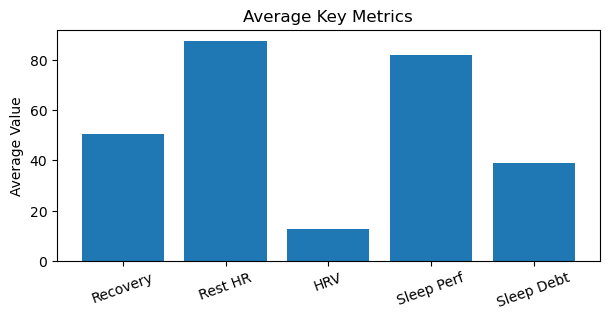

Recovery Score Distribution: {'Low': 173, 'Medium': 105, 'High': 40}

💬 Chat mode (type 'q' to quit)



Your prompt>  comment on my recovery 


[Responses API fallback] 'OpenAI' object has no attribute 'responses'

Assistant: Your recovery data indicates a mixed picture:

1. **Average Recovery (50.51)**: This suggests a moderate recovery level. Aim to improve this by focusing on recovery strategies.

2. **Recovery Distribution**: With 53% of days classified as 'Low' recovery, it's crucial to address factors affecting your recovery. 

3. **Resting Heart Rate (87.47)**: This is on the higher side, which may indicate stress or insufficient recovery. Consider incorporating relaxation techniques or adjusting your training intensity.

4. **Heart Rate Variability (HRV 12.76)**: This is relatively low, suggesting your body may be under stress. Improving sleep quality and managing stress can help.

5. **Sleep Performance (81.9)**: While decent, there's room for improvement. Aim for consistent sleep schedules and optimize your sleep environment.

6. **Sleep Debt (39.1)**: This indicates a significant amount of sleep loss. Prioritize get


Your prompt>  comment on HRV


[Responses API fallback] 'OpenAI' object has no attribute 'responses'

Assistant: The average Heart Rate Variability (HRV) of 12.76 indicates a relatively low level of autonomic nervous system flexibility, which can be associated with stress or inadequate recovery. Given the recovery distribution, with a majority of days categorized as 'Low' recovery (173 days), it may be beneficial to focus on stress management techniques, improve sleep quality, and enhance overall recovery strategies. Consider incorporating relaxation exercises, mindfulness practices, and optimizing sleep hygiene to potentially improve HRV.


In [ ]:
# --- Imports ---
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# --- Load API key from .env ---
load_dotenv("C:\\EUacademy\\.env")  # keep your path
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file.")

# --- OpenAI client (Responses API first; fallback to chat.completions) ---
from openai import OpenAI
client = OpenAI(api_key=api_key)

# ===== OpenAI Call Abstraction (like in the uploaded notebook) =====
def openai_complete(prompt: str,
                    context_summary: str,
                    system: str = "You are a health data analyst, concise and actionable.",
                    model_responses: str = "gpt-4o-mini",
                    model_chat: str = "gpt-4o-mini",
                    prefer_responses_api: bool = True) -> str:
    """
    Sends a prompt + context to OpenAI. Tries the modern Responses API first
    (similar to many new notebooks), and falls back to chat.completions if needed.
    Returns the text output only.
    """
    # Try Responses API: client.responses.create(...)
    if prefer_responses_api:
        try:
            resp = client.responses.create(
                model=model_responses,
                input=[
                    {"role": "system", "content": system},
                    {
                        "role": "user",
                        "content": (
                            "Dataset summary:\n"
                            f"{context_summary}\n\n"
                            f"User prompt: {prompt}"
                        ),
                    },
                ],
                temperature=0.2,
            )
            # New SDK convenience method:
            return resp.output_text.strip()
        except Exception as e:
            # Fall back to chat.completions below
            print(f"[Responses API fallback] {e}")

    # Fallback: Chat Completions
    resp = client.chat.completions.create(
        model=model_chat,
        messages=[
            {"role": "system", "content": system},
            {
                "role": "user",
                "content": (
                    "Dataset summary:\n"
                    f"{context_summary}\n\n"
                    f"User prompt: {prompt}"
                ),
            },
        ],
        temperature=0.2,
    )
    return resp.choices[0].message.content.strip()

# --- CSV loader ---
def load_cycles_csv(path="./physiological_cycles_today.csv"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV not found: {os.path.abspath(path)}")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    return df

# --- Summary & charts (unchanged except small tidy) ---
def analyze_df(df: pd.DataFrame) -> str:
    averages = {
        "Recovery": round(df["Recovery_score_"].mean(), 2),
        "Rest HR": round(df["Resting_heart_rate_(bpm)"].mean(), 2),
        "HRV": round(df["Heart_rate_variability_(ms)"].mean(), 2),
        "Sleep Perf": round(df["Sleep_performance_"].mean(), 2),
        "Sleep Debt": round(df["Sleep_debt_(min)"].mean(), 2) if "Sleep_debt_(min)" in df else 0,
    }

    # One-figure-per-chart, no explicit colors
    plt.figure(figsize=(7, 3))
    plt.bar(list(averages.keys()), list(averages.values()))
    plt.title("Average Key Metrics")
    plt.ylabel("Average Value")
    plt.xticks(rotation=20)
    plt.show()

    recovery_dist = {
        "Low": int((df["Recovery_score_"] < 50).sum()),
        "Medium": int(((df["Recovery_score_"] >= 50) & (df["Recovery_score_"] < 80)).sum()),
        "High": int((df["Recovery_score_"] >= 80).sum()),
    }
    print("Recovery Score Distribution:", recovery_dist)

    summary_text = [
        f"Days: {len(df)}",
        f"Avg Recovery: {averages['Recovery']}",
        f"Avg Rest HR: {averages['Rest HR']}",
        f"Avg HRV: {averages['HRV']}",
        f"Avg Sleep Performance: {averages['Sleep Perf']}",
        f"Recovery Distribution: {recovery_dist}",
    ]
    if "Sleep_debt_(min)" in df:
        avg_sleep_debt = round(df["Sleep_debt_(min)"].mean(), 2)
        summary_text.append(f"Avg Sleep Debt: {avg_sleep_debt}")
    return "\n".join(summary_text)

# --- Run once: analyze + interactive prompt loop using the new wrapper ---
csv_path = input("Enter CSV path (press Enter for './physiological_cycles_today.csv'): ").strip() or "./physiological_cycles_today.csv"
df = load_cycles_csv(csv_path)
context_summary = analyze_df(df)

print("\n💬 Chat mode (type 'q' to quit)")
while True:
    q = input("\nYour prompt> ").strip()
    if q.lower() == "q":
        print("Bye!")
        break
    if not q:
        continue
    try:
        ans = openai_complete(
            prompt=q,
            context_summary=context_summary,
            system="You are a health data analyst, concise and actionable."
            # You can set prefer_responses_api=False if you want to force chat.completions path
        )
        print("\nAssistant:", ans)
    except Exception as e:
        print("[Error]", e)
